In [1]:
import rtde_control
import rtde_receive
import numpy as np
import sys
import yaml
from matplotlib import pyplot as plt
import SimpleITK as sitk
import pickle as pkl


import pyrealsense2 as rs
import cv2
import torch
import time
from collections import deque


from force_control import z_force_control
from local_match import local_match
from img_utils import get_slice_at,visualize_local_match, flip_img

sys.path.append("../../")

from scripts.Registration3D.registration import central_normalize_img, calculate_ct2us_transform
from scripts.SurfaceContact.move import move_default_pose

from scripts.SurfaceContact.control import SurfaceContactControl
from scripts.USImageCV.models.unet import UNet
from scripts.USImageCV.utils.bunny import bunny_mask_predict, load_bunny_model,max_connected_area
%load_ext autoreload
%autoreload 2

# Connect to robot

In [2]:
# from recording_upload_server import CaptureServer

rtde_c = rtde_control.RTDEControlInterface("192.168.1.2")
rtde_r = rtde_receive.RTDEReceiveInterface("192.168.1.2")


# Connect to ultrasound image stream

In [3]:
ultrasound_vid = cv2.VideoCapture('/dev/video8')

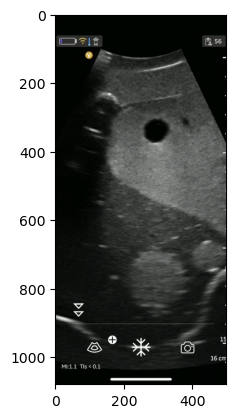

In [35]:

ret, frame = ultrasound_vid.read()		
plt.imshow(frame)

# Load pre-trained bunny segmentation model

In [5]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

trunk_model = load_bunny_model('../../scripts/USImageCV/model_weights/trunk_seg_model.pth',device)
vessel_model = load_bunny_model('../../scripts/USImageCV/model_weights/vessel_model.pth',device)

# Connect to RGB-D Camera

In [6]:
pipeline = rs.pipeline()
pipeline.start()


# Initialize surface finding controller

In [7]:
with open('../../config/pose_in_TCP_frame.yaml','r') as f:
    poses = yaml.safe_load(f)

    camera_2_tcp = poses['camera']
    probe_2_tcp = poses['probe']
    
body_color_rgb = (99, 55, 34)
body_hsv_rad = (50,50,200)
# rtde_c = rtde_r = []
sc = SurfaceContactControl(pipeline,rtde_c,rtde_r,
                           camera_2_tcp,probe_2_tcp,
                           body_color_rgb,body_hsv_rad)

In [8]:
move_default_pose(rtde_c)

410 261


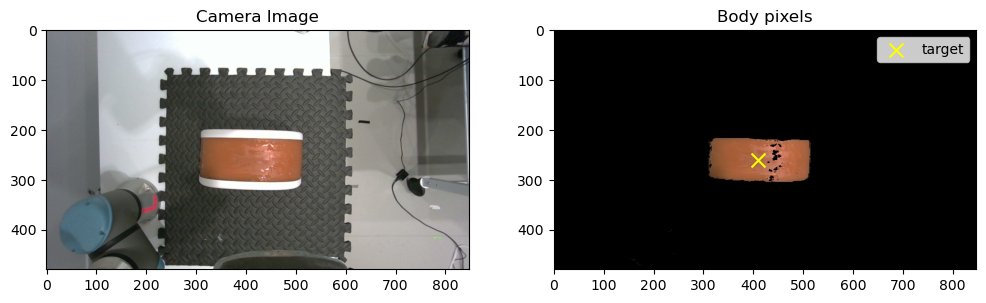

In [9]:
sc.fetchCameraStreamData()
fig = plt.figure(dpi=100,figsize = (12,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
sc.showScene([ax1,ax2])


# Probe Control functions

In [10]:

def find_surface(sc):
    for _ in range(40):
        dist = sc.mainloop()
        dist_threshold = 0.005
        if dist<dist_threshold:
            break
    print("Arrived at above target location. Start descending.")

    sc.loc_normal_control(hover_height=0.20)
    # s = input("Find surface:?")

    if sc.getContact():
        print("Contact made.")


def find_object(model,area_threshold=5000):
    '''
        model: a neural network that detects the pixels of the object to find.
    '''

    def view_optim(start_pose,target_pose,
                   search_vel=0.001,search_acc=0.1):
        # Optimize the view by traversing the robot from a start pose to a goal pose.

        # Move the TCP to the starting pose.
        rtde_c.moveL(start_pose,0.01,0.1) 
        
        # After reaching the starting pose, fire off the TCP to move towards the target_pose.
        # Setting asynchoronous=True allows the code to fly forward while the robot execute the motion independently.
        rtde_c.moveL(target_pose,search_vel,search_acc,asynchronous=True) 
        
        # In the asynchorous mode of moveL, we have to actively monitor the robot speed to determine whether the robot has stopped.
        speeds = []

        time.sleep(0.01) # This will allow the robot to start moving a little
        area_diff = deque(maxlen=3)

        max_area = 0
        optim_pose = []
        frames = []
        for i in range(1000):
            linear_tcp_speed = np.linalg.norm(rtde_r.getActualTCPSpeed()[:3])
            speeds.append(linear_tcp_speed)
            
            ret, frame = ultrasound_vid.read()	
            frames.append(frame)
            ###### Must record the curr_pose right after the image read and before the neural network inference.
            curr_pose = rtde_r.getActualTCPPose()	
            ######


            mask = bunny_mask_predict(model,frame,device)
            area = max_connected_area(mask)
            # print("area",area,"Time elapsed:",time.time()-start_time)
            area_diff.append(area)
            
            if area>max_area:
                max_area = area
                optim_pose = curr_pose
            
            if len(area_diff)>=3 and\
                np.min(area_diff)>4000 and \
                    area_diff[-1]-area_diff[-2]<0 and area_diff[-2]-area_diff[-3]<0:
                # If the area starts to consistently decline, stop the robot. 
                # print(list(area_diff))
                rtde_c.stopL() 
                # We can call stopL() to manually stop the robot during execution.
                # This is very useful pairing with the async move of moveL.

                # And move the robot to the optimal pose
                rtde_c.moveL(optim_pose,0.01,0.1)

                return max_area,frames
    
        if linear_tcp_speed<1e-4:
            return max_area,frames
    

    def y_direction_search():
        # y direction search has to be very careful, with low speed vel=0.001
        tcp_pose = rtde_r.getActualTCPPose()

        start_pose = rtde_c.poseTrans(tcp_pose,[0,-0.03,0,0,0,0])

        target_pose = rtde_c.poseTrans(tcp_pose,[0,+0.03,0,0,0,0])

        return view_optim(start_pose,target_pose,
                            search_vel = 0.01,
                            search_acc = 0.1)

    def x_direction_search():
        # x direction search can be more crude, with intermediate speed vel=0.01
        tcp_pose = rtde_r.getActualTCPPose()

        start_pose = rtde_c.poseTrans(tcp_pose,[-0.05,0,0,0,0,0])

        target_pose = rtde_c.poseTrans(tcp_pose,[+0.05,0,0,0,0,0])

        return view_optim(start_pose,target_pose,
                            search_vel = 0.01,
                            search_acc = 0.1)
    max_a = 0
    while True:
        y_direction_search()
        
        a,_ = x_direction_search()
        print('Max area',a)
        if a>=max_a:
            max_a = a
        if max_a>=area_threshold:
            break


def centralize_object(model):
    '''
        model: the neural network responsible for outputing the segmentation mask of the desired object.
    '''
    for i in range(20):
        ret, frame = ultrasound_vid.read()	
        mask = bunny_mask_predict(model,frame,device)
        z_c,x_c=np.mean(np.argwhere(mask),axis=0)

        # We have ensured that the x axis of TCP aligns with axis 1 of frame, and z axis of TCP aligns with axis[0] of frame.
        x_dir = x_c-frame.shape[1]//2
        print("Centralizing the object. Pixel distance remaining: ",np.linalg.norm(x_dir))

        if np.linalg.norm(x_dir)<20:
            break

        tcp_pose = rtde_r.getActualTCPPose()

        move_step = 1/100
        target_pose = rtde_c.poseTrans(tcp_pose,[move_step*np.sign(x_dir),0,0,0,0,0])


        rtde_c.moveL(target_pose,0.005,0.1)
    

def record_registration(model,n_samples):
    def record(start_pose,target_pose, n_waypoints = 50):
        start_loc = start_pose[:3]
        target_loc = target_pose[:3]
        waypoints = np.linspace(start_loc,target_loc,n_waypoints)
        waypoints = [list(w)+start_pose[3:] for w in waypoints]

        rtde_c.moveL(start_pose,0.01,0.1)
        # y direction search has to be very careful, with low speed vel=0.001
        tcp_pose = rtde_r.getActualTCPPose()
        start_pose = tcp_pose

        # In the asynchorous mode of moveL, we have to actively monitor the robot speed to determine whether the robot has stopped.
        speeds = []
        start_time = time.time()

        time.sleep(0.01) # This will allow the robot to start moving a little
        n_hist = 5
        areas = deque(maxlen=n_hist)

        poses=[]
        frames = []
        for w in waypoints:
            
            ret, frame = ultrasound_vid.read()
            frames.append(frame)
            ###### Must record the curr_pose right after the image read and before the neural network inference.
            curr_pose = rtde_r.getActualTCPPose()	
            poses.append(curr_pose)
            ######
            mask = bunny_mask_predict(model,frame,device)
            area = max_connected_area(mask)
            print("area",area,"Time elapsed:",time.time()-start_time)
            areas.append(area)
            if len(areas)>=n_hist and np.max(areas)<=2000:
                # If the area starts to consistently be small, stop the robot.
                # And move the robot to the start pose
                break
            rtde_c.moveL(w,0.01,0.1)
        rtde_c.moveL(start_pose,0.01,0.1)
        return frames,poses
    start_pose = rtde_r.getActualTCPPose()
    frames = []
    poses = []
    
    # Move and record in the feet direction
    target_pose = rtde_c.poseTrans(start_pose,[0,-0.03,0,0,0,0])
    f,p = record(start_pose,target_pose,n_waypoints = n_samples//2)
    
    # Make sure the order is from feet towards head
    f.reverse()
    p.reverse()

    frames+=f
    poses+=p
    # Move and record in the head direction
    target_pose = rtde_c.poseTrans(start_pose,[0,0.03,0,0,0,0])
    f,p = record(start_pose,target_pose,n_waypoints = n_samples//2)
    frames+=f
    poses+=p
    return frames,poses



def slice_matching_control(vessel_ct_slice,us_spacing):
    def search(y_step,n_iter = 20,lookback = 3):

        max_am = 0
        max_pos = rtde_r.getActualTCPPose()

        score_deque = deque(maxlen=lookback)
        for _ in range(n_iter):
            ret, frame = ultrasound_vid.read()
            pred_mask = bunny_mask_predict(vessel_model,frame,device)
            vessel_us_slice = pred_mask.T
            vessel_us_slice = sitk.GetImageFromArray(vessel_us_slice)
            vessel_us_slice.SetSpacing(us_spacing)

            t = time.time()
            _,am,_ = local_match(vessel_ct_slice,vessel_us_slice)
            print("Local match elapsed:",time.time()-t,"Match score:",am)

            curr_pose = rtde_r.getActualTCPPose()
            if am>max_am:
                max_pos = curr_pose
                max_am = am

            score_deque.append(am)
            if len(score_deque)>=lookback and np.max(score_deque)<100:
                break
            
            next_pose = rtde_c.poseTrans(curr_pose,[0,y_step,0,0,0,0])
            rtde_c.moveL(next_pose,0.01,0.1)
            
        return max_am, max_pos
    
    centralize_object(vessel_model)
            
    initial_pos = rtde_r.getActualTCPPose()

    step = 1/1000
    max_am,max_pos = search(step)

    rtde_c.moveL(initial_pos,0.01,0.1)

    step = -1/1000
    a,p = search(step)

    if a>max_am:
        max_pos = p
        max_am = a
    rtde_c.moveL(max_pos,0.01,0.1)
    return max_pos


In [11]:
# Start the control pipeline
move_default_pose(rtde_c)

In [11]:
# Start the control pipeline
move_default_pose(rtde_c)
w0 = rtde_r.getActualTCPForce()# Record force zero

find_surface(sc)

Arrived at above target location. Start descending.
Contact made.


In [12]:
target_force = 20
force_err_tolerance = 0.2
z_force_control(target_force,rtde_r,rtde_c,w0)

Current force is:1.84126910681902:  Time elapsed=00:00

Current force is:19.735911923297962:  Time elapsed=00:11

Target force reached.


True

In [13]:
find_object(trunk_model)
centralize_object(trunk_model)
trunk_pos = rtde_r.getActualTCPPose()
with open('trunk_pos.pkl','wb') as fp:
    pkl.dump(trunk_pos,fp)

Max area 8867.0
Centralizing the object. Pixel distance remaining:  8.76642913697546


In [14]:

f,p = record_registration(vessel_model,n_samples=80)

with open('registration_3d_frames.pkl','wb') as fp:
    pkl.dump({'frames':f,'waypoints':p},fp)

area 7807.0 Time elapsed: 0.3600773811340332
area 7775.0 Time elapsed: 0.7043449878692627
area 7775.0 Time elapsed: 1.3010339736938477
area 7954.0 Time elapsed: 1.949328899383545
area 7963.0 Time elapsed: 2.5899722576141357
area 8226.0 Time elapsed: 3.2528417110443115
area 8789.0 Time elapsed: 3.900841474533081
area 9265.0 Time elapsed: 4.613063097000122
area 10080.0 Time elapsed: 5.231615304946899
area 10427.0 Time elapsed: 5.85760235786438
area 19234.0 Time elapsed: 6.484349012374878
area 20039.0 Time elapsed: 7.132940769195557
area 20393.0 Time elapsed: 7.762722969055176
area 11145.0 Time elapsed: 8.394484519958496
area 10315.0 Time elapsed: 9.022690534591675
area 8906.0 Time elapsed: 9.671269655227661
area 8507.0 Time elapsed: 10.335887670516968
area 8488.0 Time elapsed: 11.01244306564331
area 5960.0 Time elapsed: 11.643509149551392
area 5906.0 Time elapsed: 12.244995355606079
area 5889.0 Time elapsed: 12.847453594207764
area 6109.0 Time elapsed: 13.386792659759521
area 5829.0 Time

In [15]:

with open('registration_3d_frames.pkl','rb') as fp:
    reg_data = pkl.load(fp)

frames,waypoints = reg_data['frames'],reg_data['waypoints']

masks = []
for frame in frames:
    masks.append(bunny_mask_predict(vessel_model,frame,device))
masks = np.array(masks)

# Get rid of the noisy predictions in the image. Only save the maximal connected component
_,masks = max_connected_area(masks,return_mask=True)

vessel_us = sitk.GetImageFromArray(masks)
with open('../../config/us_spacing.yaml') as fp:
    sp = yaml.safe_load(fp)

# Spacing Units are mm.
xspacing = sp['xspacing'] 
yspacing = sp['yspacing']
start_loc = np.array(waypoints[0][:3])
end_loc = np.array(waypoints[-1][:3])
zspacing = 1000*np.linalg.norm(start_loc-end_loc)/len(f)

vessel_us.SetSpacing((xspacing,yspacing,zspacing))

# Save checkpoint for registration
sitk.WriteImage(vessel_us,'./nifty/vessel_us.nii.gz')

# 3D Registration between US and CT

In [11]:


original_vessel_ct = sitk.ReadImage('./nifty/vessel_ct.nii.gz')
# The left-right order is different between the US image and CT image. We flip vessel_ct to make them consistent.
original_vessel_ct = flip_img(original_vessel_ct,[True,False,False])
vessel_ct = central_normalize_img(original_vessel_ct,150)



original_vessel_us = sitk.ReadImage('./nifty/vessel_us.nii.gz')
vessel_us = central_normalize_img(original_vessel_us,150)

CT2US = calculate_ct2us_transform(vessel_us,vessel_ct)

Start optimizing the transformation


100%|██████████| 10/10 [00:56<00:00,  5.67s/it]


# Select a list of locations in CT and move the robots to go to them

In [12]:
del original_vessel_ct,original_vessel_us

In [ ]:

def move_horizontal_record(target_loc_ct,us_origin):

    def move_xy(ref_pos,rtde_r,rtde_c):
        tcp = rtde_r.getActualTCPPose()
        target_pose = ref_pos[:2]+tcp[2:]
        return rtde_c.moveL(target_pose,0.01,0.1)

    target_loc_us = CT2US.TransformPoint(target_loc_ct)
    tx = -target_loc_us[-1]/1000
    ty = -target_loc_us[0]/1000
    us_x = us_origin[0]
    us_y = us_origin[1]
    curr_pose = rtde_r.getActualTCPPose()

    # x-axis in robot base frame = head-feet axis in CT frame
    # y-axis in robot base frame = left-right axis in CT frame
    target_loc_robot = [curr_pose[0],us_y+ty,0,0,0,0]

    move_xy(target_loc_robot,rtde_r,rtde_c)
    ret,frame = ultrasound_vid.read()
    return frame

In [16]:
from scripts.Registration3D.registration import visualize_vessel,get_centroid_loc


body_ct = sitk.ReadImage('./nifty/CT_phantom_regular.nii.gz')
body_ct = flip_img(body_ct,[True,False,False])
vessel_ct = sitk.ReadImage('./nifty/vessel_ct.nii.gz')
vessel_ct = flip_img(vessel_ct,[True,False,False])


with open('../../config/us_spacing.yaml') as fp:
    sp = yaml.safe_load(fp)
# Spacing Units are mm. 
us_spacing = (sp['xspacing'], sp['yspacing'])

with open('registration_3d_frames.pkl','rb') as fp:
    data = pkl.load(fp)

original_vessel_us = sitk.ReadImage('./nifty/vessel_us.nii.gz')
waypoints = data['waypoints']
probe_pos_0 = rtde_c.poseTrans(waypoints[0],sc.probe_2_tcp)
us_origin = rtde_c.poseTrans(probe_pos_0,[-original_vessel_us.GetSpacing()[0]*original_vessel_us.GetSize()[0]/(2*1000),0,0,0,0,0])



x_cand = [-80,-40,-20,0,20]
z_cand = [-10,-5,0,5,10]

target_locs = [ get_centroid_loc(vessel_ct) + np.array([x,0,z]) for x in x_cand for z in z_cand]

del original_vessel_us,data

In [14]:
with open('trunk_pos.pkl','rb') as fp:
    trunk_pos = pkl.load(fp)

True

In [41]:

observations = []
for loc in target_locs[3:4]:

    print('Calculate loc_us')
    pix = vessel_ct.TransformPhysicalPointToIndex(loc)
    target_loc_us = CT2US.TransformPoint(loc)

    print('Create vessel_ct_slice')
    # Standardize the resolution for US and CT vessel slice images.b
    vessel_ct_slice = get_slice_at(vessel_ct,pix)
    vessel_ct_slice = sitk.GetImageFromArray(vessel_ct_slice)
    vessel_ct_slice.SetSpacing(vessel_ct.GetSpacing()[:2])

    print('Slice matching contronl starts')
    rtde_c.moveL(trunk_pos,0.1,0.01)
    slice_matching_pos = slice_matching_control(vessel_ct_slice,us_spacing)
    
    print('Move horizontal')
    frame = move_horizontal_record(target_locs[3],us_origin)
    observations.append(frame)
    

Calculate loc_us
Create vessel_ct_slice
Slice matching contronl starts
Centralizing the object. Pixel distance remaining:  9.011083875093249
Local match elapsed: 0.25025320053100586 Match score: 244.8013
Local match elapsed: 0.2926185131072998 Match score: 246.18144
Local match elapsed: 0.28133654594421387 Match score: 240.23378
Local match elapsed: 0.3081934452056885 Match score: 232.04088
Local match elapsed: 0.2520263195037842 Match score: 234.65756
Local match elapsed: 0.2994880676269531 Match score: 230.34705
Local match elapsed: 0.3314204216003418 Match score: 234.3706
Local match elapsed: 0.3429841995239258 Match score: 229.33736
Local match elapsed: 0.35286474227905273 Match score: 224.77245
Local match elapsed: 0.2842562198638916 Match score: 214.0402
Local match elapsed: 0.3160881996154785 Match score: 29.270224
Local match elapsed: 0.4177706241607666 Match score: 106.77158
Local match elapsed: 0.35116147994995117 Match score: 71.58307
Local match elapsed: 0.3057582378387451 

In [20]:
max_pos = rtde_r.getActualTCPPose()

In [31]:
rtde_c.moveL(max_pos,0.1,0.01)

True

In [25]:
curr_pose = rtde_r.getActualTCPPose()

In [32]:
# Save the observations
with open('us_observations.pkl','wb') as fp:
    pkl.dump({'frame':observations,'CT_target_locs':target_locs,'CT_image':vessel_ct,'Observation Origin':get_centroid_loc(vessel_ct)},fp)

In [36]:
print('Move horizontal')
frame = move_horizontal_record(loc,us_origin)
observations.append(frame)


Move horizontal


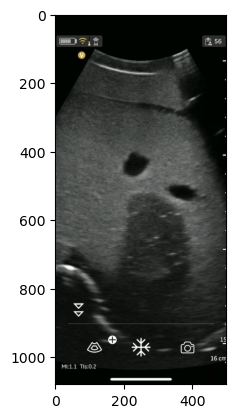

In [34]:
plt.imshow(observations[0])

1.0 0.0


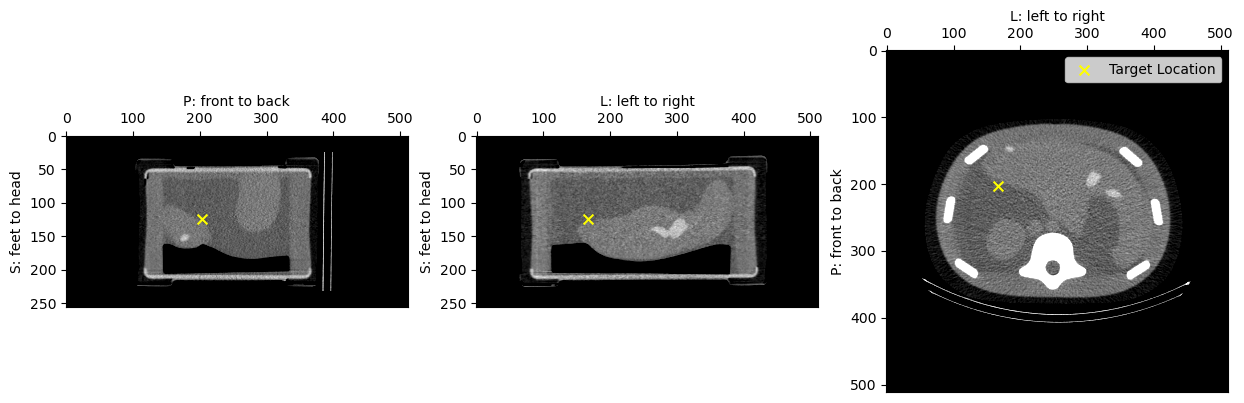

1.0 0.0


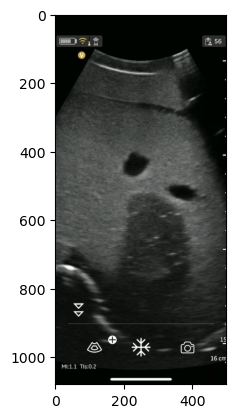

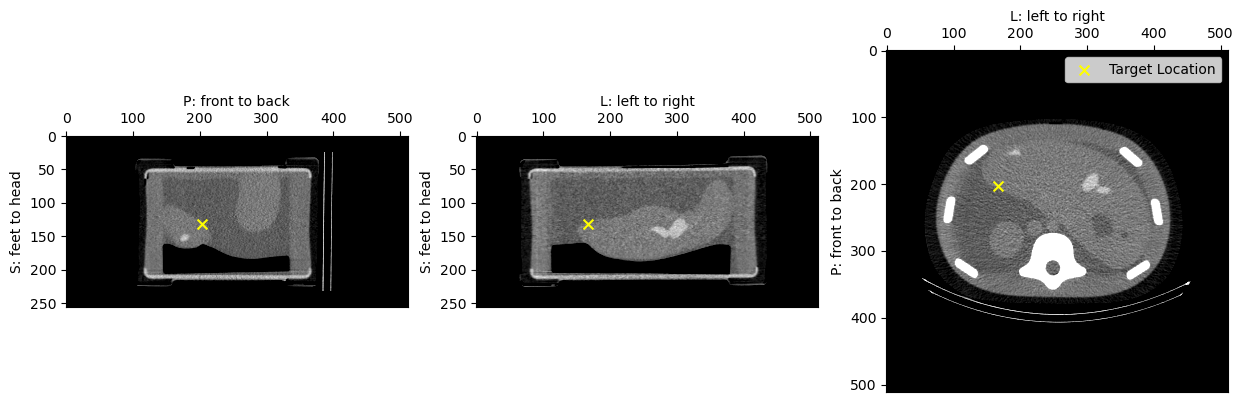

1.0 0.0


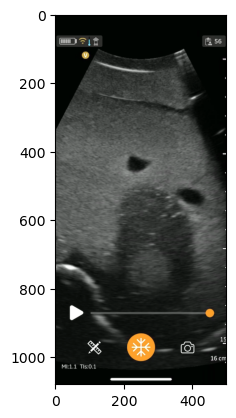

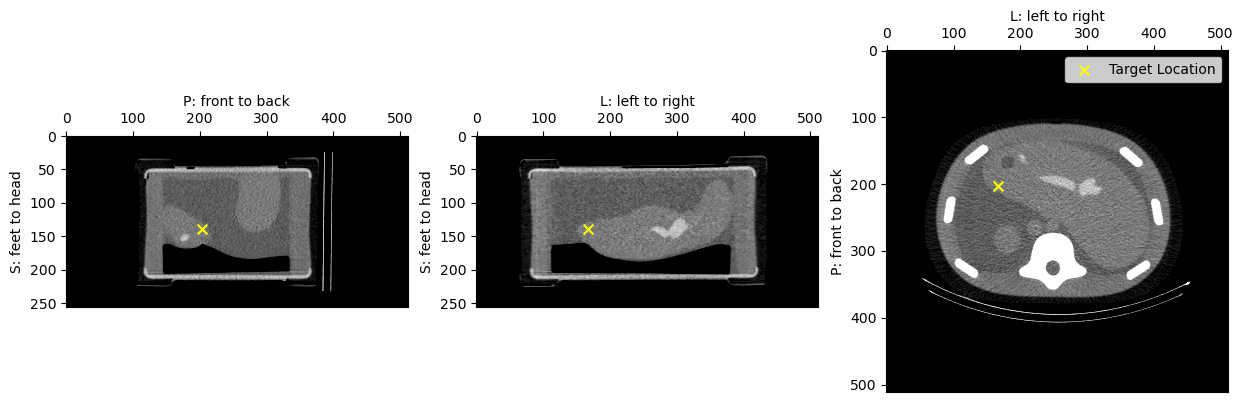

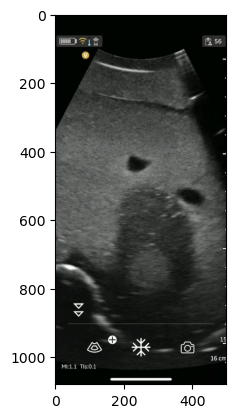

In [37]:

for i in range(len(observations)):
    loc = target_locs[i]

    pix = vessel_ct.TransformPhysicalPointToIndex(loc)
    # visualize_vessel(original_vessel_ct,pix,'Target Location')
    visualize_vessel(body_ct,pix,'Target Location',vmin=0.6,vmax=0.8)

    o = observations[i]
    plt.imshow(o,cmap = 'gray')

# Clean up

In [2]:
# Start the control pipeline
move_default_pose(rtde_c)

NameError: name 'move_default_pose' is not defined

In [1]:
ultrasound_vid.release()
pipeline.stop()

NameError: name 'ultrasound_vid' is not defined

# Useful Scripts

In [4]:
# Script for saving default pose
with open('../../config/default_pose.yaml','w') as f:
    yaml.safe_dump({'default_pose':rtde_r.getActualTCPPose()},f)